In [119]:
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [138]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.backend import set_image_data_format 
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, concatenate, add 
from tensorflow.keras import optimizers, losses, utils 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from keras.layers.merge import concatenate, add

In [157]:
X=[]
files = glob.glob("tif_data/River/*.tif")
for file in tqdm(files):
    im = tifffile.imread(file)
    img = im[:,:, [3,2,1]]/10
    X.append(img)
    

100%|██████████| 2500/2500 [00:04<00:00, 561.96it/s]


In [158]:
y=[]
files = glob.glob("tif_data/tif_mask/*.png")
for file in files:
    img = np.asarray(Image.open(file))
    y.append(img)
    

In [159]:
y=np.asarray(y)

In [160]:
X=np.asarray(X)

In [163]:
y.shape

(2500, 64, 64)

In [18]:
#y.reshape(2500,64,64,1).shape

(2500, 64, 64, 1)

In [114]:
idx=np.random.randint(0,2500)

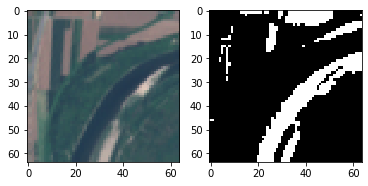

In [115]:
fig, ax= plt.subplots(1,2)
ax[0].imshow(np.array(X[idx],np.int32))
ax[1].imshow(y[idx], cmap='Greys')

In [165]:
X_val.shape#=np.asarray(X_val)

(300, 64, 64, 3)

In [164]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=117)

In [124]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [125]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [166]:
input_img = Input((64, 64, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=["accuracy"])

In [167]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 64, 64, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 64, 64, 16)   64          conv2d_59[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 64, 64, 16)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [168]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [169]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks
                 , validation_data=(X_val, y_val))

Train on 2200 samples, validate on 300 samples
Epoch 1/50
2176/2200 [============================>.] - ETA: 0s - loss: -461.6589 - accuracy: 0.2723
Epoch 00001: val_loss improved from inf to 505.45177, saving model to model-best.h5
2200/2200 [==============================] - 43s 19ms/sample - loss: -463.4769 - accuracy: 0.2722 - val_loss: 505.4518 - val_accuracy: 0.4015
Epoch 2/50
2176/2200 [============================>.] - ETA: 0s - loss: -789.5211 - accuracy: 0.2380
Epoch 00002: val_loss improved from 505.45177 to 61.05329, saving model to model-best.h5
2200/2200 [==============================] - 40s 18ms/sample - loss: -791.0184 - accuracy: 0.2373 - val_loss: 61.0533 - val_accuracy: 0.2753
Epoch 3/50
2176/2200 [============================>.] - ETA: 0s - loss: -1071.2166 - accuracy: 0.1761
Epoch 00003: val_loss improved from 61.05329 to -597.19203, saving model to model-best.h5
2200/2200 [==============================] - 41s 19ms/sample - loss: -1072.1135 - accuracy: 0.1761 - va

2176/2200 [============================>.] - ETA: 0s - loss: -2383.5755 - accuracy: 0.1206
Epoch 00026: val_loss did not improve from -2311.80264
2200/2200 [==============================] - 41s 19ms/sample - loss: -2382.9317 - accuracy: 0.1205 - val_loss: -2310.7096 - val_accuracy: 0.1461
Epoch 27/50
2176/2200 [============================>.] - ETA: 0s - loss: -2384.5272 - accuracy: 0.1183
Epoch 00027: val_loss improved from -2311.80264 to -2312.04676, saving model to model-best.h5
2200/2200 [==============================] - 41s 19ms/sample - loss: -2383.0838 - accuracy: 0.1186 - val_loss: -2312.0468 - val_accuracy: 0.1403
Epoch 28/50
2176/2200 [============================>.] - ETA: 0s - loss: -2385.1223 - accuracy: 0.1261
Epoch 00028: val_loss did not improve from -2312.04676
2200/2200 [==============================] - 41s 19ms/sample - loss: -2383.2490 - accuracy: 0.1263 - val_loss: -2309.6875 - val_accuracy: 0.1622
Epoch 29/50
2176/2200 [============================>.] - ETA: 0s

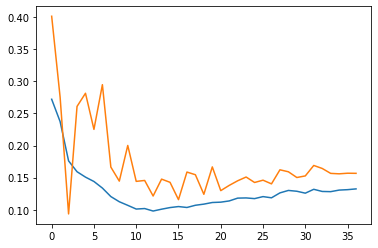

In [171]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [172]:
model.load_weights('model-best.h5')